## Set up

In [7]:
import pickle
from pathlib import Path

import keras as tfk
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

sns.set_theme()

In [2]:
EXPERIMENT = "64-efficientnet_fine_tuning"
EXPERIMENT_DIR = Path().absolute().parent / "results" / EXPERIMENT
AUGMENTED_DIR = Path().absolute().parent / "data" / "40-52"

MODEL_PATH = EXPERIMENT_DIR / "model.keras"
HISTORY_PATH = EXPERIMENT_DIR / "history.pkl"
HISTORIES_PATH = EXPERIMENT_DIR / "histories.pkl"
TRAIN_PREDICTIONS_PATH = EXPERIMENT_DIR / "train_predictions.npy"
VAL_PREDICTIONS_PATH = EXPERIMENT_DIR / "val_predictions.npy"

### Load model

In [3]:
model: tfk.Model = tfk.saving.load_model(MODEL_PATH)
model

<Functional name=functional_3, built=True>

In [4]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 96, 96, 3)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,559,448 (51.73 MB)

 Trainable params: 208,584 (814.78 KB)

 Non-trainable params: 12,933,694 (49.34 MB)

 Optimizer params: 417,170 (1.59 MB)

In [5]:
layer_weights: list[np.ndarray] = [
    model.layers[i].weights[0].numpy().flatten()
    for i in (-4, -3, -1)
]

<Axes: >

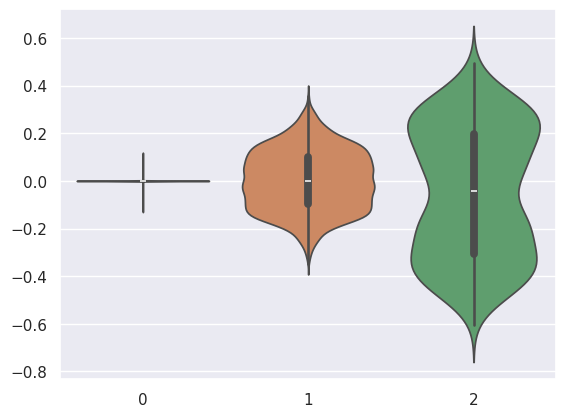

In [6]:
sns.violinplot(layer_weights)

### Load data

In [8]:
BATCH_SIZE = 128
TRAIN_TFDS_DIR = AUGMENTED_DIR / "train"
VAL_TFDS_DIR = AUGMENTED_DIR / "val"

train_dataset = tf.data.Dataset.load(str(TRAIN_TFDS_DIR)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.load(str(VAL_TFDS_DIR)).batch(BATCH_SIZE)

train_dataset

NotFoundError: /home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/40-52/train/dataset_spec.pb; No such file or directory

### Load predictions

In [ ]:
y_train_pred = np.load(TRAIN_PREDICTIONS_PATH)
y_val_pred = np.load(VAL_PREDICTIONS_PATH)

In [ ]:
y_train = np.concatenate(
    list(train_dataset.map(lambda _, y: y).as_numpy_iterator())
)
y_val = np.concatenate(
    list(val_dataset.map(lambda _, y: y).as_numpy_iterator())
)

print(y_train.shape)
print(y_val.shape)

(31688, 8)
(5592, 8)


2024-11-17 06:23:09.599840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-17 06:23:09.774343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def decode(one_hot: np.ndarray) -> np.ndarray:
    return np.argmax(one_hot, axis=1)

In [ ]:
label_train = decode(y_train)
label_val = decode(y_val)

label_train_pred = decode(y_train_pred)
label_val_pred = decode(y_val_pred)

In [ ]:
outputs = {
    "train": (label_train, label_train_pred),
    "val": (label_val, label_val_pred),
}
outputs

{'train': (array([7, 6, 0, ..., 0, 3, 1]), array([7, 6, 0, ..., 0, 5, 1])),
 'val': (array([2, 3, 7, ..., 5, 0, 2]), array([2, 3, 2, ..., 5, 0, 2]))}

### Load history

In [9]:
if HISTORY_PATH.exists():
    with HISTORY_PATH.open("rb") as f:
        history: tfk.callbacks.History = pickle.load(f)
        history_backbone = None
elif HISTORIES_PATH.exists():
    with HISTORIES_PATH.open("rb") as f:
        histories: list[tfk.callbacks.History] = pickle.load(f)
        history = histories[0]
        history_backbone = histories[1]

In [ ]:
history_df = pd.DataFrame(history_backbone.history)
f1_df = history_df.filter(like="f1_score")
history_df = history_df[history_df.columns.difference(f1_df.columns)]
history_df

,accuracy,learning_rate,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.954904,1.000000e-04,0.292170,0.965454,0.942786,0.928827,0.347251,0.937625,0.919349
1,0.955472,1.000000e-04,0.286529,0.965502,0.944143,0.917561,0.364973,0.926892,0.909156
2,0.957082,1.000000e-04,0.281066,0.966743,0.945784,0.931330,0.337678,0.939803,0.921316
3,0.955851,1.000000e-04,0.282287,0.966122,0.945847,0.929900,0.335469,0.939945,0.923641
4,0.956072,1.000000e-04,0.277213,0.965564,0.945027,0.928827,0.342381,0.936170,0.920601
...,...,...,...,...,...,...,...,...,...
88,0.963898,1.000000e-08,0.209881,0.971783,0.956419,0.930615,0.296359,0.938869,0.920064
89,0.965097,1.000000e-08,0.207871,0.972236,0.956987,0.929542,0.296774,0.938344,0.919886
90,0.963740,1.000000e-08,0.213075,0.970836,0.954936,0.930436,0.296593,0.938869,0.920064
91,0.965507,1.000000e-08,0.208394,0.972746,0.956261,0.930973,0.296453,0.938880,0.920243


## Analyse

### History

In [ ]:
molten_history = history_df.reset_index().melt(id_vars="index")
molten_history["val"] = molten_history["variable"].str.contains("val_")
molten_history["variable"] = molten_history["variable"].str.replace("val_", "")
molten_history

NameError: name 'history_df' is not defined

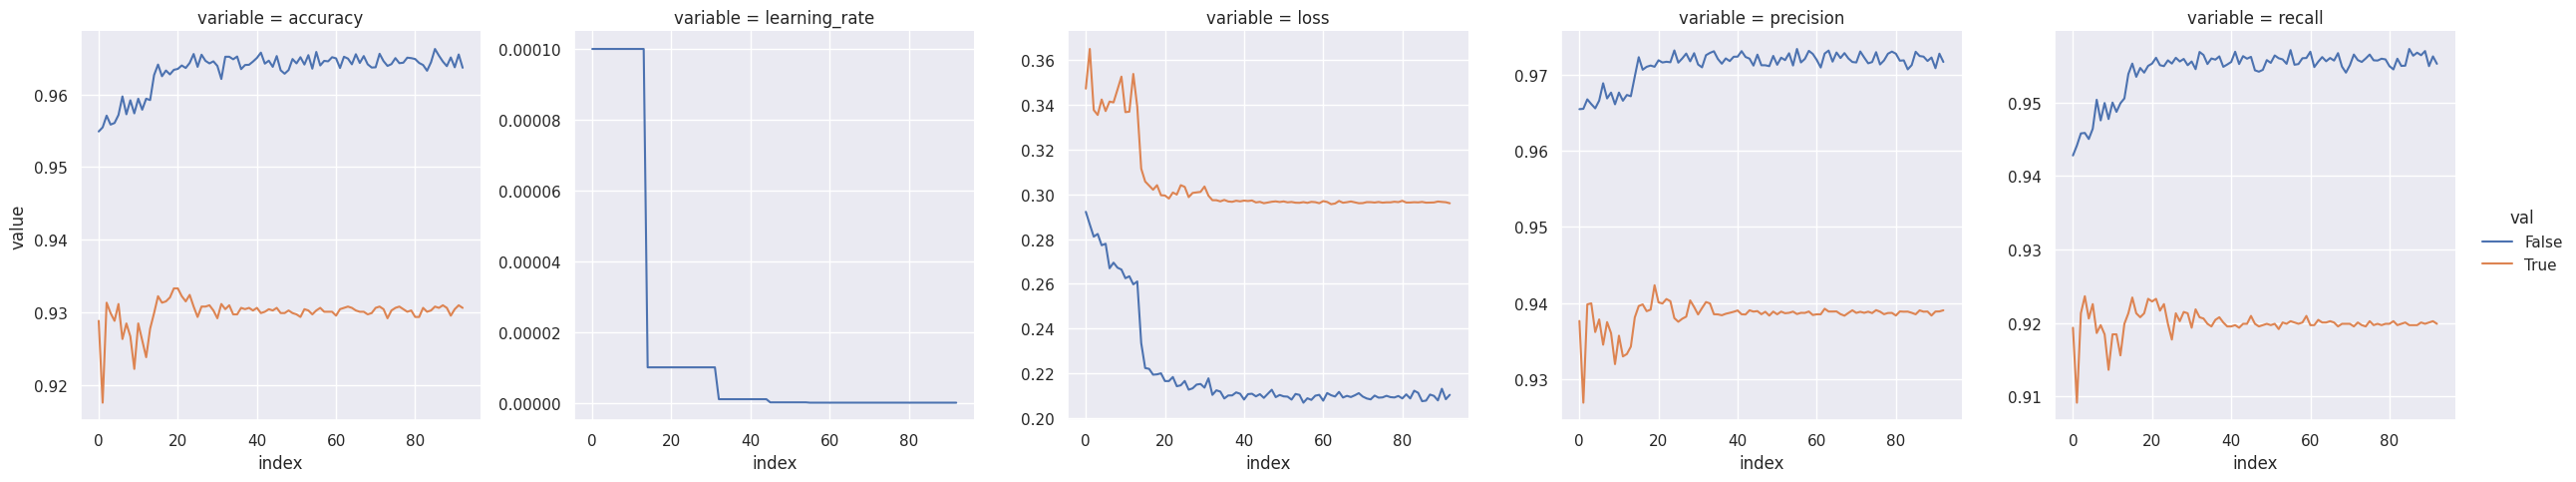

In [ ]:
sns.relplot(
    molten_history,
    x="index",
    y="value",
    col="variable",
    hue="val",
    facet_kws={"sharey": False},
    kind="line",
)

### Classification metrics

In [ ]:
for set_, (y_true, y_pred) in outputs.items():
    print(set_)
    print(classification_report(y_true, y_pred))
    print()

train
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3962
           1       0.99      0.99      0.99      3962
           2       0.96      0.92      0.94      3960
           3       0.82      0.94      0.88      3960
           4       0.91      0.97      0.93      3960
           5       0.98      0.85      0.91      3962
           6       0.99      0.93      0.96      3960
           7       1.00      0.95      0.97      3962

    accuracy                           0.94     31688
   macro avg       0.95      0.94      0.94     31688
weighted avg       0.95      0.94      0.94     31688


val
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       698
           1       0.99      0.99      0.99       698
           2       0.94      0.90      0.92       700
           3       0.80      0.93      0.86       700
           4       0.90      0.96      0.93       700
           5 

### Confusion matrices

In [ ]:
def confusion_diag_zero(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix[np.diag_indices_from(matrix)] = 0
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return ax

Text(0.5, 19.049999999999997, 'Predicted')

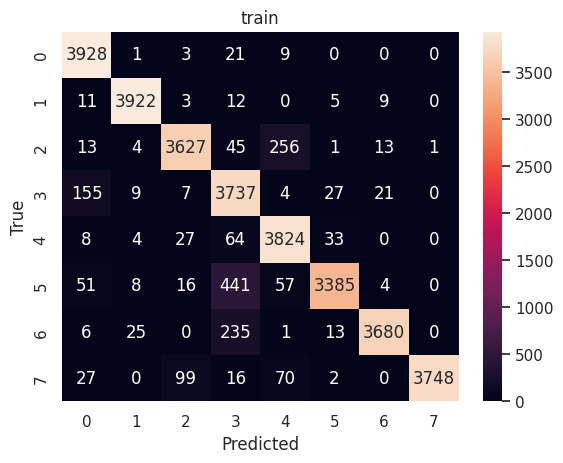

In [ ]:
ax = sns.heatmap(confusion_matrix(*outputs["train"]), annot=True, fmt="d")
ax.set_title("train")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")

<Axes: xlabel='Predicted', ylabel='True'>

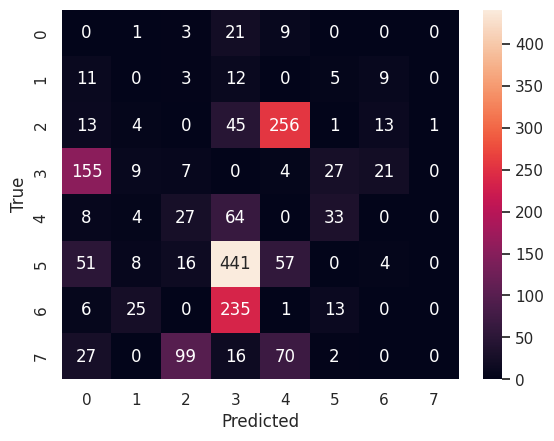

In [ ]:
confusion_diag_zero(*outputs["train"])

Text(0.5, 19.049999999999997, 'Predicted')

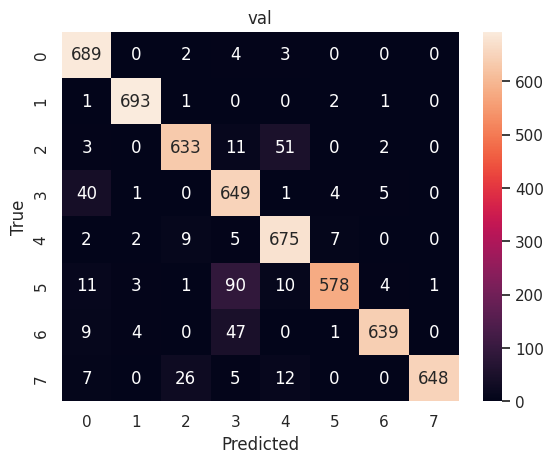

In [ ]:
ax = sns.heatmap(confusion_matrix(*outputs["val"]), annot=True, fmt="d")
ax.set_title("val")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")

<Axes: xlabel='Predicted', ylabel='True'>

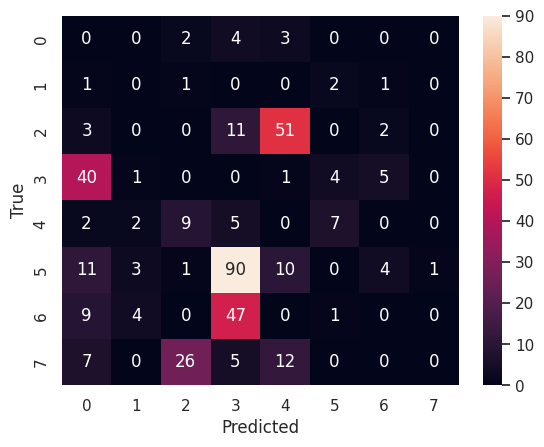

In [ ]:
confusion_diag_zero(*outputs["val"])